In [1]:
#
# Check that PyTorch is properly installed
#
import torch
print(torch.cuda.is_available())

True


In [2]:
try:
    import torchtext
    import portalocker
except:
    !pip3 install torchtext portalocker

First we need to download the WikiText2 dataset. The dataset consists of individual paragraphs, some of which are titles. We go through all paragraphs, clean them, and add all remaining paragraphs into a list. Note that we maintain the structure of paragraphs instead of merging all of them into a single list, as we want to avoid creating center and context pairs that span across paragraphs.

In [3]:
import re
import torchtext
import collections


def to_paragraphs(_items, tokenizer):
    paragraphs = []
    for item in _items:
        # Remove trailing whitespace and special characters
        item = re.sub("^\s+", "", item)
        item = re.sub("@", "", item)
        if not re.match("^=", item):
            p = tokenizer(item)
            if len(p):
                paragraphs.append(p)
                        
    return paragraphs

#
# Build list of paragraphs and print a sample
#
ds = torchtext.datasets.WikiText2(split="train")
tokenizer = torchtext.data.utils.get_tokenizer("basic_english")
paragraphs = to_paragraphs(ds, tokenizer)
print(paragraphs[5000])

['in', 'the', 'early', 'hours', 'of', '7', 'october', 'the', 'allied', 'artillery', 'and', 'mortar', 'bombardment', 'began', ',', 'targeting', 'chinese', 'positions', 'on', 'the', 'hinge', '.', 'hassett', 'moved', 'the', '3', 'rar', 'tactical', 'headquarters', 'on', 'to', 'hill', '317', 'just', 'before', 'the', 'assaulting', 'troops', 'stepped', 'off', 'the', 'line', 'of', 'departure', ',', 'allowing', 'him', 'to', 'direct', 'the', 'battle', 'from', 'a', 'forward', 'position', 'and', 'to', 'co', '-', '<unk>', 'fire', 'support', '.', 'waiting', 'for', 'the', 'fog', 'to', 'lift', 'so', 'that', 'the', 'artillery', 'could', 'fire', 'until', 'the', 'last', 'safe', 'moment', ',', 'the', 'attack', 'finally', 'began', 'at', '08', '00', '.', 'b', 'company', 'moved', 'off', 'down', 'the', '<unk>', ',', 'with', 'two', '-', 'up', 'and', 'one', '-', 'in', '-', 'depth', ',', 'using', 'the', 'trees', 'and', 'long', 'grass', 'for', 'concealment', '.', 'initially', 'it', 'seemed', 'that', 'the', 'chine

Next we again tokenize the text and build a vocabulary. However, this time we will ignore all words that appear less than a given number of times in the text, and instead use a special token in the vocabulary that will be used for all token that are not in the vocabulary during encoding. 

In [4]:
def build_vocab(paragraphs, min_freq = 50):
        vocab = torchtext.vocab.build_vocab_from_iterator(paragraphs, min_freq=min_freq, specials=["<unk>"])
        vocab.set_default_index(vocab["<unk>"])
        return vocab

def encode_paragraphs(paragraphs, vocab):
    return [[vocab[_token] for _token in p] for p in paragraphs]

vocab = build_vocab(paragraphs)
encoded_paragraphs = encode_paragraphs(paragraphs, vocab)

The next step in the processing is to create pairs consisting of a center token and a list of context tokens. We will do this paragraph for paragraph and later skip outputs which are two short. 

In [5]:
def yield_context(paragraphs, window_size = 8):
    for p in paragraphs:
        half = window_size // 2
        #
        # If we are not yet at the last token in the paragraph, 
        # yield window and advance center. 
        #
        for index, center in  enumerate(p):
            context = p[max(0, index - half):index]
            context.extend(p[index + 1:min(len(p), index + half + 1)])
            yield center, context

test_paragraphs = [["This", "is", "a", "short", "test", "paragraph", "to", "try", "out", "things"]]
iter = yield_context(test_paragraphs, window_size = 4)
for i in range(10):
  print(next(iter))


('This', ['is', 'a'])
('is', ['This', 'a', 'short'])
('a', ['This', 'is', 'short', 'test'])
('short', ['is', 'a', 'test', 'paragraph'])
('test', ['a', 'short', 'paragraph', 'to'])
('paragraph', ['short', 'test', 'to', 'try'])
('to', ['test', 'paragraph', 'try', 'out'])
('try', ['paragraph', 'to', 'out', 'things'])
('out', ['to', 'try', 'things'])
('things', ['try', 'out'])


In [6]:
def print_sample(center, context):
    left_context = context[:len(context) // 2]
    right_context = context[len(context) // 2:]
    print(f"{[vocab.lookup_token(idx) for idx in left_context]} {vocab.lookup_token(center)} {[vocab.lookup_token(idx) for idx in right_context]}")
    
iter = yield_context(encoded_paragraphs)
#
# Advance by a few items, then print a few examples
#
for i in range(10800):
    next(iter)
for i in range(10):
    center, context = next(iter)
    if len(context) != 8:
        continue
    print_sample(center, context)

['17', 'team', 'of', '24'] players [',', '<unk>', 'from', 'an']
['team', 'of', '24', 'players'] , ['<unk>', 'from', 'an', 'initial']
['of', '24', 'players', ','] <unk> ['from', 'an', 'initial', 'pool']
['24', 'players', ',', '<unk>'] from ['an', 'initial', 'pool', 'of']
['players', ',', '<unk>', 'from'] an ['initial', 'pool', 'of', '49']
[',', '<unk>', 'from', 'an'] initial ['pool', 'of', '49', 'young']
['<unk>', 'from', 'an', 'initial'] pool ['of', '49', 'young', 'women']
['from', 'an', 'initial', 'pool'] of ['49', 'young', 'women', '.']
['an', 'initial', 'pool', 'of'] 49 ['young', 'women', '.', 'two']
['initial', 'pool', 'of', '49'] young ['women', '.', 'two', 'girls']


We are now ready to put all this into a PyTorch data set, use a data loader to load a batch and print a few examples from the batch to verify that our code works. This is not an introduction into datasets, but basically a dataset is an object that implements *__getitem__* and *__len__* so that it can be handled by a data loader. As our text is rather short, we can afford to build all center / context pairs in memory when the dataset is created.

In [7]:
import torch

class CBOWDataSet(torch.utils.data.Dataset):

    def yield_context(self, paragraphs):
        window_size = self._window_size
        for p in paragraphs:
            half = window_size // 2
            for index, center in  enumerate(p):
                context = p[max(0, index - half):index]
                context.extend(p[index + 1:min(len(p), index + half + 1)])
                yield center, context
    
    def __init__(self, min_freq = 50, window_size = 8):
        super().__init__()
        self._window_size = window_size
        #
        # Build vocabulary
        #
        ds = torchtext.datasets.WikiText2(split="train")
        tokenizer = torchtext.data.utils.get_tokenizer("basic_english")
        paragraphs = []
        for item in ds:
            # Remove trailing whitespace and special characters
            item = re.sub("^\s+", "", item)
            item = re.sub("@", "", item)
            if not re.match("^=", item):
                p = tokenizer(item)
                if len(p):
                    paragraphs.append(p)
        self._vocab = torchtext.vocab.build_vocab_from_iterator(paragraphs, min_freq=min_freq, specials=["<unk>"])
        self._vocab.set_default_index(self._vocab["<unk>"])
        #
        # Encode paragraphs
        #
        encoded_paragraphs = [[self._vocab[_token] for _token in p] for p in paragraphs]
       #
        # Create a list of all center / context pairs
        #
        self._x = []
        self._y = []
        for center, context in self.yield_context(encoded_paragraphs):
            if len(context) == self._window_size:
                self._x.append(center)
                self._y.append(context)
                
    def __getitem__(self, index):
        if index < len(self._x):
            return self._x[index], self._y[index]
        else:
            raise KeyError

    def __len__(self):
        return len(self._x)

    
    def get_vocab(self):
        return self._vocab

    
def collate_fn(list):
    X = []
    Y = []
    for index, [center, context] in enumerate(list):
        Y.append(context)
        X.append(center)
            
    X = torch.tensor(X, dtype=torch.long)
    Y = torch.tensor(Y, dtype=torch.long)
    return X, Y 



In [8]:
ds = CBOWDataSet(min_freq=50)
BATCH_SIZE = 4
training_data = torch.utils.data.DataLoader(ds, batch_size = BATCH_SIZE, collate_fn = collate_fn)

Let us try this. We expect that each batch consists of two tensor of dimensions $B$ (the batch size) respectively $B \times W$ where $W$ is the window size. Each row corresponds to a center index and a list of context indices.

In [9]:
iter = training_data.__iter__()
for i in range(50):
    next(iter)
for i in range(2):
    X, Y = next(iter)
    for b in range(BATCH_SIZE):
        x, y = X[b].item(), Y[b].tolist()
        print_sample(x, y)

['it', 'met', 'with', 'positive'] sales ['in', 'japan', ',', 'and']
['met', 'with', 'positive', 'sales'] in ['japan', ',', 'and', 'was']
['with', 'positive', 'sales', 'in'] japan [',', 'and', 'was', 'praised']
['positive', 'sales', 'in', 'japan'] , ['and', 'was', 'praised', 'by']
['sales', 'in', 'japan', ','] and ['was', 'praised', 'by', 'both']
['in', 'japan', ',', 'and'] was ['praised', 'by', 'both', 'japanese']
['japan', ',', 'and', 'was'] praised ['by', 'both', 'japanese', 'and']
[',', 'and', 'was', 'praised'] by ['both', 'japanese', 'and', 'western']


Next we build our model - we use a PyTorch embedding, which is essentially a matrix, where the number of embedding is the size of the vocabulary and the dimension is the model dimension which we can choose freely. On top of the embedding, we have a linear layer which translates back from the model dimension into the vocabulary. As recommended in [this blog post](https://towardsdatascience.com/word2vec-with-pytorch-implementing-original-paper-2cd7040120b0), I use the *max_norm* parameter of the embedding to avoid overtraining.

In [10]:
EMBED_MAX_NORM = 1

class CBOW(torch.nn.Module):
    
    def __init__(self, model_dim, V, bias = False):
        super().__init__()
        self.embedding = torch.nn.Embedding(
            num_embeddings=V,
            embedding_dim=model_dim,
            max_norm=EMBED_MAX_NORM,
        )
        self.linear = torch.nn.Linear(
            in_features=model_dim,
            out_features=V,
            bias = bias
        )
        
        
    def forward(self, Y):
        E = self.embedding(Y).mean(axis=1)
        U = self.linear(E)
        return U
        
   
    def get_embedding(self, index):
        with torch.no_grad():
            return self.embedding(torch.tensor([index], dtype=torch.long))

In [11]:
import tqdm

def train(model, epochs, train_data_loader, lr = 0.00025, device = "cpu", loss_fn = torch.nn.functional.cross_entropy):
    losses = []
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    lr_lambda = lambda epoch: (epochs - epoch) / epochs
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda, verbose = False)
    for epoch in range(epochs):
        epoch_loss = 0
        items_in_epoch = 0
        for X, Y in tqdm.tqdm(train_data_loader,  desc = f"Epoch {epoch}"):
            items_in_epoch = items_in_epoch + 1
            f = model(Y.to(device))
            targets = X.to(device)
            loss = loss_fn(f, targets)            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())
            epoch_loss = epoch_loss + loss.item()

        epoch_loss = epoch_loss / items_in_epoch
        print(f"Completed epoch {epoch}, mean loss in epoch is {epoch_loss}. Current learning rate is {optimizer.param_groups[0]['lr']}")
        scheduler.step()

    return losses


Let us now train. I found that large batch sizes and large learning rates work well in combination with the Adam optimizer. We do of course train on the GPU if that is available. We plot the losses after completing the training and save the results. I found that with the chosen parameters, 5 - 10 epochs are sufficient to produce reasonable results. Even on my not so modern GPU, this took less than 2 minutes.

In [12]:

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device {device}")
D = 300
BATCH_SIZE = 20000
V = len(ds.get_vocab())
print(f"Size of vocabulary: {V}")
model = CBOW(model_dim=D, V=V, bias = False)
print(model)
model = model.to(device)
    
training_data = torch.utils.data.DataLoader(ds, batch_size = BATCH_SIZE, collate_fn = collate_fn, shuffle = True, num_workers = 2)


Using device cuda
Size of vocabulary: 4056
CBOW(
  (embedding): Embedding(4056, 300, max_norm=1)
  (linear): Linear(in_features=300, out_features=4056, bias=False)
)


In [13]:
losses = train(model, lr=0.1, epochs=7, train_data_loader = training_data, device = device)

Epoch 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93/93 [00:08<00:00, 10.83it/s]


Completed epoch 0, mean loss in epoch is 5.3891845364724436. Current learning rate is 0.1


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93/93 [00:08<00:00, 11.50it/s]


Completed epoch 1, mean loss in epoch is 4.903358582527407. Current learning rate is 0.08571428571428572


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93/93 [00:08<00:00, 11.40it/s]


Completed epoch 2, mean loss in epoch is 4.777398827255413. Current learning rate is 0.07142857142857144


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93/93 [00:08<00:00, 11.36it/s]


Completed epoch 3, mean loss in epoch is 4.68927211658929. Current learning rate is 0.05714285714285714


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93/93 [00:08<00:00, 11.37it/s]


Completed epoch 4, mean loss in epoch is 4.628661350537372. Current learning rate is 0.04285714285714286


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93/93 [00:08<00:00, 11.47it/s]


Completed epoch 5, mean loss in epoch is 4.567510220312303. Current learning rate is 0.02857142857142857


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93/93 [00:08<00:00, 11.43it/s]

Completed epoch 6, mean loss in epoch is 4.486164754436862. Current learning rate is 0.014285714285714285


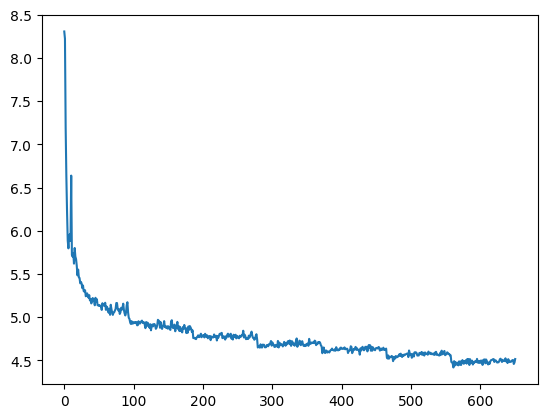

In [14]:
import matplotlib.pyplot as plt
plt.plot(losses) 

In [15]:
#
# Save embeddings and vocab for later use
#
torch.save(model.embedding.weight, "context_embeddings.pt")
torch.save(model.linear.weight, "center_embeddings.pt")
torch.save(ds.get_vocab(), "vocab.pt")

In [16]:
#
# Load embeddings and vocab. Note that the embeddings are stored 
# with dimensions V x D, so the embeddings are the rows
#
vocab = torch.load("vocab.pt")
context_embeddings = torch.load("context_embeddings.pt")
center_embeddings = torch.load("center_embeddings.pt")
V = len(vocab)
D = context_embeddings.shape[1]
print(f"V = {V}, D = {D}")
print(f"Shape of context embeddings: {context_embeddings.shape}")
print(f"Shape of center embeddings:  {center_embeddings.shape}")

V = 4056, D = 300
Shape of context embeddings: torch.Size([4056, 300])
Shape of center embeddings:  torch.Size([4056, 300])


In [17]:
#
# Print the 5 most similar words for a given token
#
def print_most_similar(token, embeddings, vocab):
    #
    # Normalize embeddings
    #
    _embeddings = torch.nn.functional.normalize(embeddings, dim = 1)
    #
    # get u, the embedding of our token
    #
    u = _embeddings[vocab[token], :]
    #
    # Now we need to perform the dot product of u with every other word, i.e. with
    # every row of _embeddings. But this simply amounts to taking the matrix product
    #
    v = torch.matmul(_embeddings, u)
    #
    # Sort this
    #
    values, indices = torch.sort(v, descending=True)
    print(f"Most similar token for {token}")
    for i in range(5):
        print(f"      {vocab.lookup_token(indices[i])} -- {values[i]}")
    
print_most_similar("france", context_embeddings, vocab)
print_most_similar("king", context_embeddings, vocab)
print_most_similar("father", context_embeddings, vocab)

Most similar token for france
      france -- 0.9999999403953552
      italy -- 0.661055326461792
      germany -- 0.6301742792129517
      japan -- 0.62759929895401
      australia -- 0.620962917804718
Most similar token for king
      king -- 0.9999999403953552
      son -- 0.5954159498214722
      earl -- 0.59091717004776
      archbishop -- 0.57264244556427
      pope -- 0.5617164969444275
Most similar token for father
      father -- 1.0000001192092896
      mother -- 0.7656291127204895
      son -- 0.7561269998550415
      daughter -- 0.7459317445755005
      wife -- 0.7104585766792297


In [18]:
print_most_similar("france", center_embeddings, vocab)
print_most_similar("king", center_embeddings, vocab)
print_most_similar("father", center_embeddings, vocab)

Most similar token for france
      france -- 1.0
      italy -- 0.7698928117752075
      spain -- 0.6993325352668762
      germany -- 0.6846596598625183
      russia -- 0.6496986746788025
Most similar token for king
      king -- 1.0
      pope -- 0.6784377694129944
      lord -- 0.6100903749465942
      henry -- 0.5989689230918884
      queen -- 0.5779016017913818
Most similar token for father
      father -- 0.9999999403953552
      mother -- 0.8434839248657227
      wife -- 0.7766066789627075
      daughter -- 0.774500846862793
      brother -- 0.7713660597801208
